In [3]:
import numpy as np
import sys
from input_output import read_day_ahead_prices, read_ef, save_results
from utilities import *
from Simulation import Simulation
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy
from tqdm import tqdm


## Preprocessing for degradation data



In [4]:
goal = "quick_analysis" #"paper" #"test"

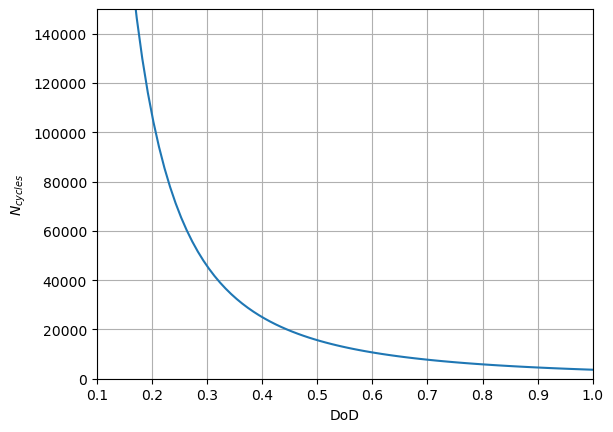

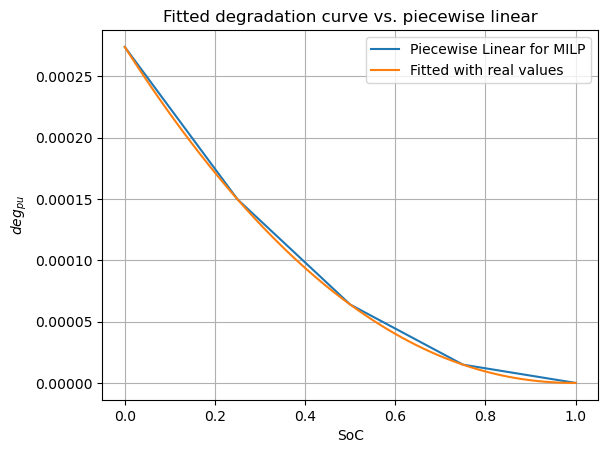

In [5]:
full_dod_cycle_life_years = 10
shelf_life_years = 20

k=-2.1 # B - constant
full_dod_cycle_life = 365*full_dod_cycle_life_years # A - constant


######################################
#Get points on the line
######################################
n_segments = 4
degradation_soc_query_points = np.linspace(0,1,n_segments+1)
degradation_values = 1/full_dod_cycle_life*(1-degradation_soc_query_points)**(-k)


# ######################################
# #No degradation
# ######################################
# degradation_soc_query_points = [0,1]
# degradation_values = [0,0]

hourly_shelf_degradation = 1/(shelf_life_years*24*365)

plt.plot(np.linspace(1e-3,1-1e-3,100), full_dod_cycle_life*np.power(np.linspace(1e-3,1-1e-3,100),k))
plt.ylim([0,150000])
plt.xlim([0.1,1])
plt.xlabel("DoD")
plt.ylabel("$N_{cycles}$")
plt.grid(True, which='both')
plt.show()

#From SoC to deg.percent
degradation_profile = dict(zip(degradation_soc_query_points,degradation_values))
degradation_profile = dict(sorted(degradation_profile.items()))

plt.figure()
plt.plot(degradation_profile.keys(), degradation_profile.values())
plt.plot(np.linspace(1e-5,1-1e-5,100), 1/(full_dod_cycle_life*np.power(1-np.linspace(1e-5,1-1e-5,100),k)))
plt.grid(visible = True, which='both')
plt.xlabel("SoC")
plt.ylabel("$deg_{pu}$")
plt.title("Fitted degradation curve vs. piecewise linear")
plt.legend(['Piecewise Linear for MILP', 'Fitted with real values'])
plt.show()


## Setup simulations
### Input values of the simulations

Sets up the list of "simulations".

In [6]:
# Modified manually to obtain different points on the Pareto front
p_co2_list = [1e-5, 1e-3, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 1000] #Eur/kg = kEur/t-CO2
c_rate_list = [1, 0.7, 0.5, 0.25]
horizon_list = [48]

simulations = [Simulation(batt_cap=2220,
                          eff_round_trip=0.855,
                          c_rate=c,
                          soc_init=1,
                          soc_max=1,
                          soc_min=0,
                          p_co2=p,
                          self_discharge_per_hour=4.7e-6,
                          shelf_life_years=shelf_life_years,
                          degradation_profile=degradation_profile,
                          replacement_cost=105*2220,#eur batt_price_up
                          salvage_value=105*2220*0.1,#eur batt_price_up
                          life_cycle_emissions=60*2220, #kg
                          start_date="01.01.2019",
                          end_date="01.01.2020",
                          price_data="2019 day ahead", #text given for info only
                          emission_data="04_EmissionsData/AEF_DE.csv",
                          textinfo="aef", #text given for info only
                          save_results=True,
                          folder_name="aef",
                          horizon=h)
               for c in c_rate_list for p in p_co2_list for h in horizon_list]

## Optimization problem definition
This section defines the optimization problem with all input parameters, and outputs the results

In [7]:
def get_optimized_schedule_with_degradation(timestamps,  # from dataframe
                           purchase_costs,  # a list
                           degradation_profile,
                           degradation_cost_money,
                           degradation_cost_emissions,
                           shelf_life_years,
                           max_charging_power,  # kW
                           max_discharging_power,  # kW
                           self_discharge_per_hour,
                           DP_shelf,
                           capacity=0,  # kWh
                           eff_round_trip=0.8,  # [0-1]
                           max_SOC=1,
                           min_SOC=0,  # [0-1]
                           init_soc = 1,
                           final_soc = None,
                           full_result=False,
                           gap = 1e-2,
                           p_co2 = None):

    if final_soc == None:
        final_soc = init_soc
    eff_charge = np.sqrt(eff_round_trip)
    eff_discharge = np.sqrt(eff_round_trip)

    horizon = len(purchase_costs)

    feedin_costs = purchase_costs

    ### Create the problem
    batt_prob = gurobipy.Model(name='BatteryDispatch')

    ### Declare decision variables
    pcc_feedin = batt_prob.addVars(horizon, name="Pcc_feedin", ub=0, lb=-max_discharging_power)
    pcc_purchase = batt_prob.addVars(horizon, name="Pcc_purchase", ub=max_charging_power, lb=0)
    pcc_pos_indicator = batt_prob.addVars(horizon, name="bPccPos", vtype=gurobipy.GRB.BINARY)
    soc = batt_prob.addVars(horizon + 1, name="SOC", ub=max_SOC, lb=min_SOC)
    DP = batt_prob.addVars(horizon, name="DP", lb=DP_shelf)
    deg = batt_prob.addVars(horizon+1, name="deg")
    Delta = batt_prob.addMVar((horizon+1,len(degradation_profile)),lb=0, ub=1, name="Delta") #weights of points
    delta = batt_prob.addMVar((horizon+1,len(degradation_profile)-1), vtype=gurobipy.GRB.BINARY) #chosen segment

    obj_normalization_factor = 1

    if p_co2 != None:
        obj_normalization_factor = 1/(1+p_co2)

    ### Objective with degradation
    obj = batt_prob.setObjective(
        (pcc_feedin.prod([x/obj_normalization_factor for x in feedin_costs]) + pcc_purchase.prod([x/obj_normalization_factor for x in purchase_costs])) +
        sum(DP) * ( (degradation_cost_money+degradation_cost_emissions)/obj_normalization_factor ),
        sense=gurobipy.GRB.MINIMIZE)

    ###Constraints

    # 1-Initial & final SOC
    batt_prob.addConstr(soc[horizon] == final_soc, name="SOC Cycle")
    batt_prob.addConstr(soc[0] == init_soc, name="SOC init")

    # 2-Charging-discharging behaviour
    for i in range(1, horizon + 1):
        batt_prob.addConstr(soc[i] * capacity ==
                            pcc_purchase[i - 1] * eff_charge
                            + pcc_feedin[i - 1] / eff_discharge
                            + soc[i - 1] * capacity * (1-self_discharge_per_hour), name=f"Charging t={i}")

    # 3-Positivity binary variable
    batt_prob.addConstrs((pcc_purchase[i] <= pcc_pos_indicator[i] * max_charging_power) for i in range(horizon))
    batt_prob.addConstrs((pcc_feedin[i] >= (pcc_pos_indicator[i] - 1) * max_discharging_power) for i in range(horizon))


    # 4-Binary variables for special ordered sets
    batt_prob.addConstrs(delta[i][:].sum() == 1 for i in range(horizon+1))
    batt_prob.addConstrs(Delta[i][:].sum() == 1 for i in range(horizon+1))

    batt_prob.addConstrs(Delta[i][:] @ np.array(list(degradation_profile.values())) == deg[i] for i in range(horizon+1))
    batt_prob.addConstrs(Delta[i][:] @ np.array(list(degradation_profile.keys())) == soc[i] for i in range(horizon+1))

    # print("Picking delta")
    batt_prob.addConstrs(delta[i][0] >= Delta[i][0] for i in range(horizon+1))
    batt_prob.addConstrs(delta[i][j] + delta[i][j-1] >= Delta[i][j]
                         for i in range(horizon+1) for j in range(1,len(degradation_profile)-1))
    batt_prob.addConstrs(delta[i][-1] >= Delta[i][-1] for i in range(horizon+1))
    # print("Picked delta")

    # 5-Degradation at each operation
    batt_prob.addConstrs(DP[t] >= (deg[t] - deg[t+1])/2 for t in range(horizon))
    batt_prob.addConstrs(DP[t] >= -(deg[t] - deg[t+1])/2 for t in range(horizon))

    batt_prob.Params.MIPGap = gap
    batt_prob.Params.TimeLimit = 60
    
    if any([c < 0 for c in purchase_costs]) and goal != "paper":
        #computation slower during negative price periods
        batt_prob.Params.MIPGap = 0.05

    batt_prob.optimize()


    if batt_prob.getAttr(gurobipy.GRB.Attr.Status) != gurobipy.GRB.OPTIMAL:
        print(batt_prob.getAttr(gurobipy.GRB.Attr.Status))
        if batt_prob.getAttr(gurobipy.GRB.Attr.Status) != gurobipy.GRB.TIME_LIMIT:
            raise Exception("Soluton non-optimal")

        # print("Optimal solution found:")
        # print(batt_prob.objVal*obj_normalization_factor)
        # print("Normalization factor:")
        # print(obj_normalization_factor)

    soc_schedule = np.array([soc[i].X for i in range(horizon + 1)])
    pcc_feedin_schedule = np.array([pcc_feedin[i].X for i in range(horizon)])
    pcc_purchase_schedule = np.array([pcc_purchase[i].X for i in range(horizon)])
    pcc_schedule = np.add(pcc_feedin_schedule, pcc_purchase_schedule)
    DP_schedule = np.array([DP[i].X for i in range(horizon)])
    # pcc_pos_indicator_schedule = np.array([pcc_pos_indicator[i].X for i in range(horizon)])

    if full_result:
        cumulative_grid_cost = np.cumsum(np.multiply(pcc_purchase_schedule, purchase_costs)
                                      + np.multiply(pcc_feedin_schedule, feedin_costs))
        degradation = np.cumsum(DP_schedule)

        df = pd.DataFrame({"ts": timestamps, "pcc_schedule": np.append(pcc_schedule, 0),
                           "pcc_purchase_schedule": np.append(pcc_purchase_schedule, 0),
                           "pcc_feedin_schedule": np.append(pcc_feedin_schedule, 0),
                           "soc_schedule": soc_schedule,
                           "cumulative_grid_cost": np.insert(cumulative_grid_cost, 0, 0),
                           "DP": np.append(DP_schedule, 0),
                           "cumulative_degr_cost": np.insert(degradation*(degradation_cost_money+degradation_cost_emissions), 0, 0),
                           "grid_electricity_price": np.append(purchase_costs,0)
                           })
        return df

    else:
        return pd.DataFrame({"ts": timestamps, "pcc_schedule": pcc_schedule})

## Simulations to compute the Pareto front

In [ ]:
from win10toast import ToastNotifier

i = 0
gap = 1e-2

for simu in simulations:
    i=i+1

    print(f"Simulation {i}/{len(simulations)} started.")
    print(f"c_rate: {simu.c_rate}")
    print(f"p_co2: {simu.p_co2}")
    print(f"horizon: {simu.horizon}")

    horizon = simu.horizon

    schedule = pd.DataFrame(columns=["ts", "pcc_schedule",
                           "pcc_purchase_schedule",
                           "pcc_feedin_schedule",
                           "soc_schedule",
                           "cumulative_grid_cost",
                           "DP",
                           "cumulative_degr_cost", "grid_electricity_price"])

    # Read data
    prices = read_day_ahead_prices(simu.start_date, simu.end_date) #Eur/MWh
    emissions = read_ef(simu.emission_data, simu.start_date, simu.end_date) #kg/MWh, g/kWh

    costs = combined_objective_cost(prices, emissions, w_emissions=simu.p_co2) #Eur/MWh

    delta_T = (costs.ts.iloc[1] - costs.ts.iloc[0])
    DP_shelf = 1/(simu.shelf_life_years*365*24)

    setattr(simu, 'delta_T_hours', delta_T.seconds // 3600)

    ts = list(costs.ts)
    ts.append(costs.ts.iloc[-1] + delta_T)

    soc_init = simu.soc_init

    for t_start in tqdm(range(len(costs.combined_cost)-horizon+1)):


        last_optim = (t_start == len(costs.combined_cost)-horizon)
        optimized_horizon = get_optimized_schedule_with_degradation(ts[t_start:t_start+horizon+1],
                                          list(costs.combined_cost.iloc[t_start:t_start+horizon]/1000),  # a list !!!! Eur/kWh
                                           degradation_profile=simu.degradation_profile,
                                           degradation_cost_money=simu.replacement_cost - simu.salvage_value,
                                           degradation_cost_emissions=simu.life_cycle_emissions * simu.p_co2, #in eur-equivalent g/kWh * Eur/g
                                           shelf_life_years=simu.shelf_life_years,
                                           max_charging_power=simu.batt_cap * simu.c_rate,  # kW
                                           max_discharging_power=simu.batt_cap * simu.c_rate,  # kW
                                           capacity=simu.batt_cap,  # kWh
                                           eff_round_trip=simu.eff_round_trip,  # [0-1]
                                           max_SOC=simu.soc_max,
                                           min_SOC=simu.soc_min,
                                           self_discharge_per_hour=simu.self_discharge_per_hour,
                                           full_result=True,
                                           DP_shelf=DP_shelf,
                                           init_soc = soc_init,
                                           final_soc = simu.soc_init,# if last_optim else soc_init,
                                           gap=gap)

        first_step = pd.DataFrame(optimized_horizon.iloc[0]).T
        second_step = pd.DataFrame(optimized_horizon.iloc[1]).T


        if schedule.empty: 
            schedule = pd.concat([schedule,first_step], ignore_index=True)

            schedule.loc[schedule.index[-1],'cumulative_grid_cost'] = second_step.iloc[0].cumulative_grid_cost
            schedule.loc[schedule.index[-1],'cumulative_degr_cost'] = second_step.iloc[0].cumulative_degr_cost

        else:
            schedule = pd.concat([schedule,first_step], ignore_index=True)
            schedule.loc[schedule.index[-1],'cumulative_grid_cost'] = second_step.cumulative_grid_cost.iloc[0] + schedule.cumulative_grid_cost.iloc[-2]
            schedule.loc[schedule.index[-1],'cumulative_degr_cost'] = second_step.cumulative_degr_cost.iloc[0] + schedule.cumulative_degr_cost.iloc[-2]

        soc_init = second_step['soc_schedule'].iloc[0]

    schedule = pd.concat([schedule, pd.DataFrame(optimized_horizon.iloc[1:])], ignore_index=True)
    schedule.loc[schedule.index[-horizon:],'cumulative_grid_cost'] = schedule.iloc[-horizon:].cumulative_grid_cost + schedule.loc[schedule.index[-horizon-1],'cumulative_grid_cost']
    schedule.loc[schedule.index[-horizon:],'cumulative_degr_cost'] = schedule.iloc[-horizon:].cumulative_degr_cost + schedule.loc[schedule.index[-horizon-1],'cumulative_degr_cost']

    schedule["money_balance_grid"] = np.insert(-np.cumsum(np.multiply(schedule.pcc_schedule[:-1].to_numpy()/1000, prices.prices.to_numpy())), 0, 0)
    schedule["co2_balance_grid"] = np.insert(np.cumsum(np.multiply(schedule.pcc_schedule[:-1].to_numpy()/1000, emissions.mef.to_numpy())), 0, 0)
    schedule["degradation"] = np.insert(np.cumsum(np.array(schedule.DP))[:-1],0,0)
    schedule["real_degradation"] = np.insert(compute_real_degr(1/full_dod_cycle_life, -k, np.array(schedule.soc_schedule), hourly_shelf_degradation),0,0)
    degradation = schedule.degradation.iloc[-1]
    real_degradation = schedule.real_degradation.iloc[-1]

    setattr(simu, 'money', schedule.money_balance_grid.iloc[-2])
    setattr(simu, 'co2', schedule.co2_balance_grid.iloc[-2])
    setattr(simu, 'degradation', degradation)
    setattr(simu, 'degradation_co2', simu.life_cycle_emissions * degradation)
    setattr(simu, 'degradation_money', (simu.replacement_cost-simu.salvage_value)*degradation)
    setattr(simu, 'real_degradation', real_degradation)
    setattr(simu, 'real_degradation_co2', simu.life_cycle_emissions * real_degradation)
    setattr(simu, 'real_degradation_money', (simu.replacement_cost-simu.salvage_value)*real_degradation)

    if simu.save_results:
        save_results(simu, schedule, costs)

    print(f"Solution found. Results:\n\tMoney:\t{simu.money} Eur\n\tCO2:\t{simu.co2} kg")
    print(f"Degradation:\t{degradation} pu\n\tCO2_deg:\t{degradation*simu.life_cycle_emissions} kg"
          f"\n\tMoney_deg:\t{(simu.replacement_cost-simu.salvage_value)*degradation}")
    n = ToastNotifier()
    n.show_toast("Notification",  f"Simulation {i}/{len(simulations)} finished.\n"+ f"Solution found. Results:\n\tMoney:\t{simu.money}\n\tCO2:\t{simu.co2}")

Simulation 1/72 started.
c_rate: 1
p_co2: 1e-05
horizon: 48


  1%|          | 90/8713 [00:32<51:18,  2.80it/s] 

## Plotting to analyze the results

In [ ]:
%matplotlib qt
from scipy.signal import savgol_filter

fig, ax = plt.subplots(9,1,layout='constrained',sharex='all', figsize = (9,6))

ax[0].step(prices.ts, prices.prices, where = "post", color = "r", label="Prices")
ax[0].grid(True)

ax[1].step(emissions.ts, savgol_filter(emissions.mef, 1, 0), where = "post", color = "g", label = "Emissions")
ax[1].grid(True)

ax[2].plot(schedule.ts, schedule.soc_schedule, label="SOC", color = "m")
ax[2].grid(True)

ax[3].step(schedule.ts, schedule.pcc_schedule, where = "post", color = "r", label="Power")
ax[3].grid(True)

ax[4].plot(schedule.ts, schedule.money_balance_grid, label="Money earned", color = "b")
ax[4].grid(True)

ax[5].plot(schedule.ts, schedule.co2_balance_grid, label="CO2 emitted", color = "k")
ax[5].grid(True)

ax[6].step(costs.ts, costs.combined_cost, where = "post", label="general_cost", color = "b")
ax[6].grid(True)

ax[7].plot(schedule.ts, schedule.degradation, label="degradation", color = "g")
ax[7].grid(True)

ax[8].step(schedule.ts, schedule.DP, where = "post", label="DP", color = "r")
ax[8].grid(True)

[axe.legend(loc='upper left') for axe in ax]


plt.xticks(rotation = 30);
plt.show()